# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [477]:
# # Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [485]:
from load_data import load_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
import seaborn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats
import numpy as np
import statistics

# Classifiers and kernels

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics


data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

features = data.drop(columns=['label'])
label = data.label


# Splitting data in train and test group
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2)

# functie van maken??
y_train_bin = []
for val in y_train:
  if val == 'T12':
    y_train_bin.append(0)
  else:
    y_train_bin.append(1) 

The number of samples: 113
The number of columns: 160


## Preprocessing

### Removing outliers

In [486]:
# Create the dataframe
outlier_feat = []
for feature in X_train.columns:
    # IQR
    Q1 = np.percentile(X_train[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_train[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
 
    if not IQR == 0:
        # Upper bound
        X_train.loc[X_train[feature] > (Q3+1.5*IQR),feature] = Q3
        # Lower bound
        X_train.loc[X_train[feature] < (Q1-1.5*IQR),feature] = Q1


for feature in X_test.columns:
    
    # IQR
    Q1 = np.percentile(X_test[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_test[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    if not IQR == 0:
        # Upper bound
        X_test.loc[X_test[feature] > (Q3+1.5*IQR),feature] = Q3
        # Lower bound
        X_test.loc[X_test[feature] < (Q1-1.5*IQR),feature] = Q1


/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Scaling

In [487]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = features.columns)


## Feature selection

### T-test

In [488]:
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns) # make df from numpy
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_train.columns)
# X_train_scaled_df['Label'] = y_train_bin
# X_train_T12 = X_train_scaled_df.groupby('Label').get_group(0)
# X_train_T34 = X_train_scaled_df.groupby('Label').get_group(1)
# X_train_T12 = X_train_T12.drop(columns = ['Label'])
# X_train_T34 = X_train_T34.drop(columns = ['Label'])

# # ttest
# _,pval = stats.ttest_ind(X_train_T12,X_train_T34)



# sig_feat = []
# for id, val in enumerate(pval):
#   if val < 0.05/X_train_scaled_df.shape[1]:
#     sig_feat.append(list(X_train.columns)[id])
# print(f'Number of significant different features: {len(sig_feat)}')

# X_train_sig = X_train_scaled_df[sig_feat]
# X_test_sig = X_test_scaled_df[sig_feat]

# # # Pairplot of sign features
# # X_train_sig.columns =['Feature'+ str(pc) for pc in range(1,len(sig_feat)+1)]
# # X_train_sig['Grade'] = y_train_bin
# # pair_plot = seaborn.pairplot(X_train_sig, hue = 'Grade')

### Greedy

In [489]:
# cfs = RandomForestClassifier(n_estimators=5, bootstrap=True)


# t_it = np.zeros(159)
# for it in range(20):
#     print(it)
#     cfs = KNeighborsClassifier(n_neighbors=5)
#     sfs = SequentialFeatureSelector(cfs,n_features_to_select=5)
#     X_train_fs = sfs.fit_transform(X_train_scaled, y_train)
#     it = sfs.get_support()
#     t_it = np.vstack([t_it,it])


# voting = np.sum(t_it, axis=0)

# THRES = 10
# sig_feat = []
# for id, value in enumerate(voting):
#     if value > THRES:
#         sig_feat.append(list(X_train.columns)[id])

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns) # make df from numpy
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_train.columns)
# X_train_sig = X_train_scaled_df[sig_feat]
# X_test_sig = X_test_scaled_df[sig_feat]

# X_train_sig
# # X_test_fs = sfs.transform(X_test_scaled)

cfs = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(cfs,n_features_to_select=60)
X_train_fs = sfs.fit_transform(X_train_scaled, y_train)
X_test_fs = sfs.transform(X_test_scaled)


## PCA

In [483]:
# N_COMP = 10
# pca = PCA(n_components=N_COMP)
# pca.fit(X_train_sig)
# X_train_pca = pca.transform(X_train_sig)
# X_test_pca = pca.transform(X_test_sig)


# seaborn.scatterplot(x=X_train_pca[:,0],y=X_train_pca[:,1],hue=y_train)
# scatter_data = pd.DataFrame(X_train_pca[:,:], columns = ['Principal component' + str(pc) for pc in range(1,N_COMP+1)])
# scatter_data['Stage'] = y_train_bin
# seaborn.pairplot(scatter_data, hue = 'Stage')
# print(scatter_data)

# Classifier

In [484]:

X_train_sig = X_train_fs
X_test_sig = X_test_fs

# Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

# clsfs = [KNeighborsClassifier(), RandomForestClassifier(),QuadraticDiscriminantAnalysis(),GaussianNB(),LinearDiscriminantAnalysis(),svmlin, svmpoly, svmrbf]
clsfs = [KNeighborsClassifier(n_neighbors=10)]

for clf in clsfs:
    # Fit classifier
    clf.fit(X_train_sig,y_train)
    y_pred_train=clf.predict(X_train_sig)
    print(clf)
    acc_train = (y_train==y_pred_train).sum()/len(X_train_sig)
    print(f'Train data acc: {acc_train}')
    y_pred_test = clf.predict(X_test_sig)
    acc_test = (y_test==y_pred_test).sum()/len(X_test_sig)
    print(f'Test data acc: {acc_test}')



KNeighborsClassifier(n_neighbors=10)
Train data acc: 0.8555555555555555
Test data acc: 0.5217391304347826


#### Optimization

In [435]:
## Optimization
### KNN
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
X_train_sig_a = X_train_sig
y_train_a = y_train.to_numpy()

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_sig_a,y_train_a):
    # Split the data properly
    X_validation = X_train_sig_a[validation_index]
    y_validation = y_train_a[validation_index]
    
    X_test_op = X_train_sig_a[test_index]
    y_test_op = y_train_a[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 31, 2))}
    knn = KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test_op)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test_op, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
# seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
# print(results)


# Use the optimal parameters without any tuning to validate the optimal classifier
clf = KNeighborsClassifier(n_neighbors=optimal_n)

# Fit on the entire dataset
clf.fit(X_train_sig, y_train)

# Test the classifier on the indepedent replication data
probabilities = clf.predict_proba(X_test_sig)
scores = probabilities[:, 1]

# Get the auc
auc = metrics.roc_auc_score(y_test, scores)
print(f'THe AUC on the replication set is {auc} using a {clf.n_neighbors}-NN classifier')


knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train_sig, y_train)
score_train_kNN = knn.score(X_train_sig, y_train)
score_test_kNN = knn.score(X_test_sig, y_test)
print(f"Training result kNN: {score_train_kNN}")
print(f"Test result kNN: {score_test_kNN}")

Best classifier: k=7
Best classifier: k=11
Best classifier: k=5
Best classifier: k=7
Best classifier: k=7
The optimal N=7
THe AUC on the replication set is 0.6785714285714286 using a 7-NN classifier
Training result kNN: 0.8444444444444444
Test result kNN: 0.6086956521739131


### RF

Best classifier: n=10
Best classifier: n=11
Best classifier: n=20
Best classifier: n=30
Best classifier: n=8
The optimal N=11
        auc   n         set
0  0.962500  10        test
1  0.945216  10  validation
2  0.839506  11        test
3  0.941699  11  validation
4  0.901235  20        test
5  0.956757  20  validation
6  0.790123  30        test
7  0.966795  30  validation
8  0.796296   8        test
9  0.948263   8  validation


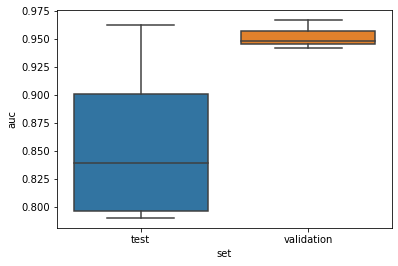

In [436]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
X_train_sig_a = X_train_sig
y_train_a = y_train.to_numpy()

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_sig_a,y_train_a):
    # Split the data properly
    X_validation = X_train_sig_a[validation_index]
    y_validation = y_train_a[validation_index]
    
    X_test = X_train_sig_a[test_index]
    y_test = y_train_a[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_estimators": list(range(1, 50))}
    rf = RandomForestClassifier(criterion= "gini", bootstrap = True, min_samples_leaf = 5)
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(rf, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: n={clf.n_estimators}')
    best_n_neighbors.append(clf.n_estimators)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'n': clf.n_estimators,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'n': clf.n_estimators,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
print(results)
